# Connect to drive

In [ ]:
# This code mounts your Google Drive to the Google Colab environment.
# It allows you to access files stored in your Google Drive directly from Colab.
# After running this code, you will be prompted to authorize Colab to access your Google Drive.
# Once authorized, you can read from and write to your Google Drive as if it were a local directory.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import the required libraries

In [ ]:
# Import Library
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import math

# Preparation

In [ ]:
# Define Directories
train_dir = "/content/drive/MyDrive/Bangkit 2024/Split_Augmentation/Dataset/train"
valid_dir = "/content/drive/MyDrive/Bangkit 2024/Split_Augmentation/Dataset/valid"
test_dir = "/content/drive/MyDrive/Bangkit 2024/Split_Augmentation/Dataset/test"

In [ ]:
# Image Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

train_batches = train_datagen.flow_from_directory(train_dir, target_size=(229, 229), batch_size=32, class_mode='categorical')
valid_batches = valid_datagen.flow_from_directory(valid_dir, target_size=(229, 229), batch_size=32, class_mode='categorical')
test_batches = test_datagen.flow_from_directory(test_dir, target_size=(229, 229), batch_size=32, class_mode='categorical', shuffle=False)

Found 4011 images belonging to 3 classes.
Found 1284 images belonging to 3 classes.
Found 1290 images belonging to 3 classes.


# Load Pretrained Model

In [ ]:
# Retrieve One Batch of Images and Labels
imgs, labels = next(train_batches)

In [ ]:
# Load Pretrained Model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(229, 229, 3))
base_model.summary()
print(type(base_model))

219055592/219055592 [==============================] - 1s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 229, 229, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 114, 114, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 114, 114, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (

# Build Model and Training

In [ ]:
# Build the Model
model = models.Model(inputs=base_model.input, outputs=base_model.output)
model.trainable = False

# Add GlobalAveragePooling2D and Dense layer for classification
x = layers.GlobalAveragePooling2D()(model.output)
x = layers.Dense(3, activation='softmax')(x)

# Final model
final_model = models.Model(inputs=model.input, outputs=x)

# Compile Model
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Add Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train Model
steps_per_epoch = math.ceil(train_batches.samples / train_batches.batch_size)
validation_steps = math.ceil(valid_batches.samples / valid_batches.batch_size)

history = final_model.fit(
    train_batches,
    validation_data=valid_batches,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=30,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/30
126/126 [==============================] - 1427s 11s/step - loss: 0.7463 - accuracy: 0.6634 - val_loss: 0.5550 - val_accuracy: 0.7593
Epoch 2/30
126/126 [==============================] - 31s 242ms/step - loss: 0.4695 - accuracy: 0.8098 - val_loss: 0.4195 - val_accuracy: 0.8310
Epoch 3/30
126/126 [==============================] - 34s 272ms/step - loss: 0.3793 - accuracy: 0.8539 - val_loss: 0.3727 - val_accuracy: 0.8598
Epoch 4/30
126/126 [==============================] - 31s 247ms/step - loss: 0.3194 - accuracy: 0.8873 - val_loss: 0.3101 - val_accuracy: 0.8824
Epoch 5/30
126/126 [==============================] - 31s 247ms/step - loss: 0.2767 - accuracy: 0.9110 - val_loss: 0.3028 - val_accuracy: 0.8832
Epoch 6/30
126/126 [==============================] - 31s 246ms/step - loss: 0.2464 - accuracy: 0.9240 - val_loss: 0.3123 - val_accuracy: 0.8715
Epoch 7/30
126/126 [==============================] - 31s 247ms/step - loss: 0.2263 - accuracy: 0.9292 - val_loss: 0.2384 - val_ac

# Visualize Model Performance

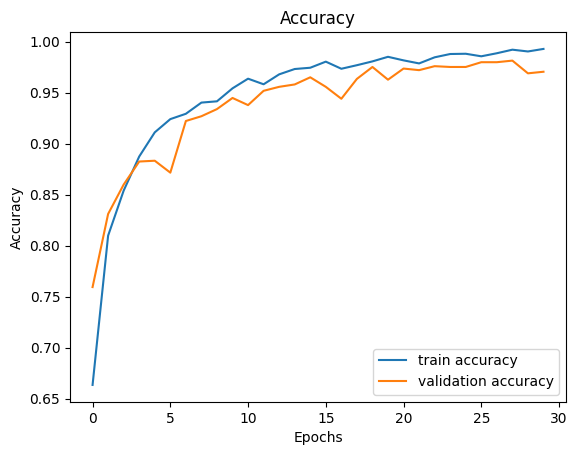

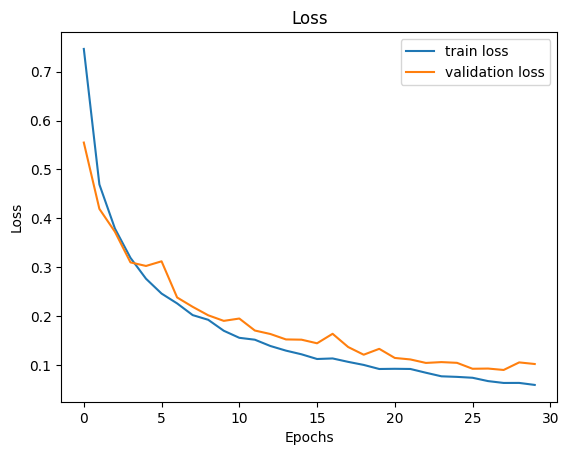

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the Model

In [ ]:
test_loss, test_accuracy = final_model.evaluate(test_batches, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

41/41 [==============================] - 497s 12s/step - loss: 0.0858 - accuracy: 0.9814
Test Accuracy: 0.9814
Test Loss: 0.0858


# Predict on Test Data

41/41 [==============================] - 11s 194ms/step
Confusion Matrix
[[359  15   4]
 [  1 450   3]
 [  0   1 457]]
Classification Report
              precision    recall  f1-score   support

    Immature       1.00      0.95      0.97       378
      Mature       0.97      0.99      0.98       454
      Normal       0.98      1.00      0.99       458

    accuracy                           0.98      1290
   macro avg       0.98      0.98      0.98      1290
weighted avg       0.98      0.98      0.98      1290



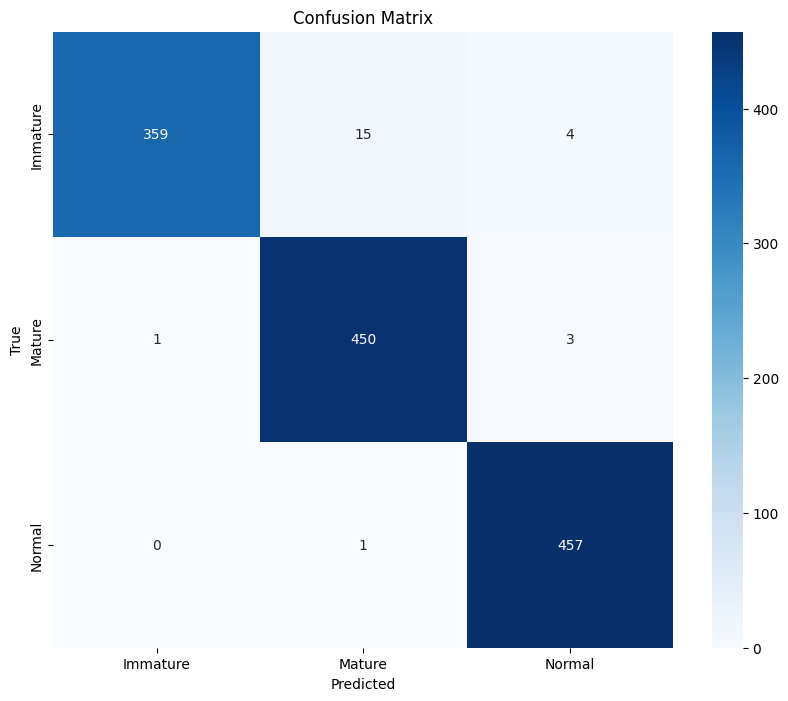

In [ ]:
# Get the class labels
class_labels = list(test_batches.class_indices.keys())

# Reset the test_batches generator
test_batches.reset()

# Predict on the test data
predictions = final_model.predict(test_batches, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_batches.classes

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix')
print(conf_matrix)

# Classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report')
print(report)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Interactive Image Classification

FileUpload(value={}, accept='image/*', description='Upload')

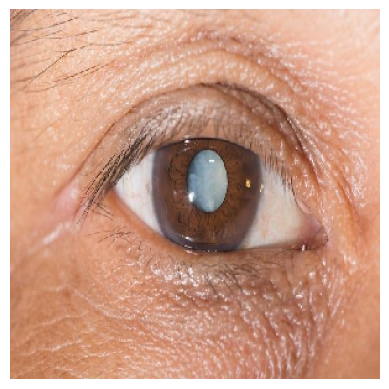

1/1 [==============================] - 4s 4s/step
Predicted Label for katarak.jpg: Mature


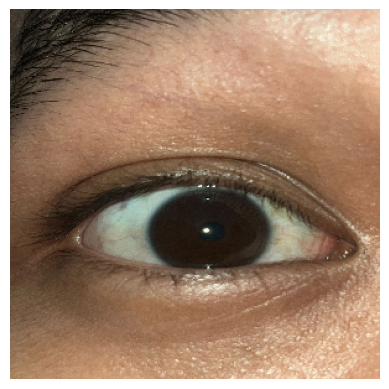

1/1 [==============================] - 0s 39ms/step
Predicted Label for WhatsApp Image 2024-06-02 at 17.25.16_89102211.jpg: Normal


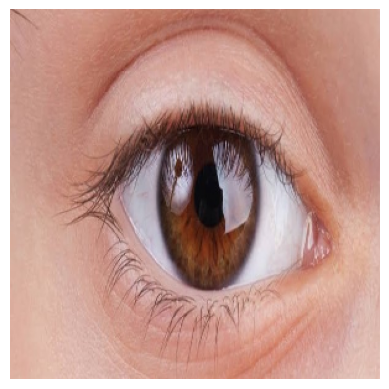

1/1 [==============================] - 0s 36ms/step
Predicted Label for news24_coid_1594833706.jpeg: Normal


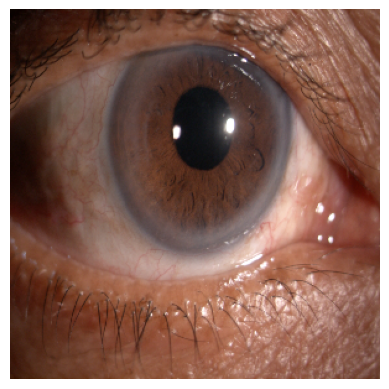

1/1 [==============================] - 0s 35ms/step
Predicted Label for post-op.jpg: Immature


In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    # Load the image with the target size of 299x299
    img = image.load_img(image_path, target_size=(229, 229))
    # Convert the image to an array
    img_array = image.img_to_array(img)
    # Expand dimensions to match the input shape of the model
    img_array = np.expand_dims(img_array, axis=0)
    # Preprocess the image using the Inception-ResNet-V2 preprocess function
    img_array = tf.keras.applications.inception_resnet_v2.preprocess_input(img_array)
    return img_array

# Function to predict the label of the image
def predict_image(image_path):
    # Load and preprocess the image
    img_array = load_and_preprocess_image(image_path)
    # Make a prediction using the final model
    single_prediction = final_model.predict(img_array)
    # Get the predicted class index
    predicted_class = np.argmax(single_prediction, axis=1)
    # Get the predicted label from the class labels
    predicted_label = class_labels[predicted_class[0]]
    return predicted_label

# File upload widget to upload images
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)

# Callback function when a file is uploaded
def on_file_upload_change(change):
    for filename, file_info in upload_widget.value.items():
        # Save the uploaded file
        with open(filename, 'wb') as f:
            f.write(file_info['content'])
        # Display the uploaded image
        img = image.load_img(filename, target_size=(299, 299))
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        # Make a prediction
        predicted_label = predict_image(filename)
        print(f"Predicted Label for {filename}: {predicted_label}")

# Observe changes in the file upload widget
upload_widget.observe(on_file_upload_change, names='value')
# Display the file upload widget
display(upload_widget)

# Save the Model

In [ ]:
import os

MODEL_BASE_PATH = "/content/drive/MyDrive/Bangkit 2024"
PROJECT_NAME = "H5"
SAVE_MODEL_NAME = "inceptionresnetv2.h5"
save_model_path = os.path.join(MODEL_BASE_PATH, PROJECT_NAME, SAVE_MODEL_NAME)
if os.path.exists(os.path.join(MODEL_BASE_PATH, PROJECT_NAME)) == False:
    os.makedirs(os.path.join(MODEL_BASE_PATH, PROJECT_NAME))

inception = InceptionResNetV2(weights='imagenet')

print('Saving Model At {}...'.format(save_model_path))
inception.save(save_model_path,include_optimizer=False)

225209952/225209952 [==============================] - 6s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saving Model At /content/drive/MyDrive/Bangkit 2024/H5/inceptionresnetv2.h5...
